# Pacchetti

In [1]:
import pyBspline as Bs
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
#import matplotlib.colors as mcolors
from matplotlib.colors import Normalize
import matplotlib.cm as cm
import scipy
from scipy.misc import derivative
from scipy.optimize import curve_fit
import pandas as pd
import copy
import pandas as pd
import os
import scipy.special
import re
import FFT as esFFT
from imp import reload 

###
def norm(x):
    return np.sqrt(np.sum(np.power(x,2.0)))   

In [2]:
#
def plot_sol(fig,n,xB,yB,x,y,c,title):
    
    ax = fig.add_subplot(n)
    ax.plot(xB, yB, color= "black",label="Bspline")
    sc = ax.scatter(x,y,c=c,cmap=cmap)
    plt.colorbar(sc)
    ax.set_aspect('equal')
    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)
    plt.title(title)
    
    return

In [3]:
#
def plot_matrix(sm,file_png=None):
    #
    sm2 = sm.copy()
    sm2["index"] = sm2.index
    #
    new = sm2.melt(id_vars=['index'])# = sm.index
    #
    new2 = new.copy()
    new2["index"] = [ i[0] for i in new2["index"]]
    new2["variable"] = [ i[0] for i in new2["variable"]]
    #new2["value"] = [np.complex(i) for i in new2["value"] ]
    new2["real"] = np.real(new2["value"])
    new2["imag"] = np.imag(new2["value"])
    new2["abs"] = np.absolute(new2["value"])
    new2["phase"] = np.angle(new2["value"])/np.pi
    df = new2
    
    #
    fig = plt.figure ( 0 , figsize = ( 15 , 10 ) )

    cmap = 'RdYlBu'

    #
    ax = fig.add_subplot(221)
    sc = ax.scatter(df["index"],df["variable"],c=df["real"],cmap = 'RdYlBu')
    plt.colorbar(sc)
    plt.xlim(min(df["index"]),max(df["index"]))
    plt.ylim(min(df["index"]),max(df["index"]))
    ax.set_aspect('equal')
    plt.title("stiffness matrix : real")

    #
    ax = fig.add_subplot(222)
    sc = ax.scatter(df["index"],df["variable"],c=df["imag"],cmap = 'RdYlBu')
    plt.colorbar(sc)
    plt.xlim(min(df["index"]),max(df["index"]))
    plt.ylim(min(df["index"]),max(df["index"]))
    ax.set_aspect('equal')
    plt.title("stiffness matrix : imag")

    #
    ax = fig.add_subplot(223)
    sc = ax.scatter(df["index"],df["variable"],c=df["abs"],cmap = 'RdYlBu')
    plt.colorbar(sc)
    plt.xlim(min(df["index"]),max(df["index"]))
    plt.ylim(min(df["index"]),max(df["index"]))
    ax.set_aspect('equal')
    plt.title("stiffness matrix : abs")

    #
    ax = fig.add_subplot(224)
    sc = ax.scatter(df["index"],df["variable"],c=df["phase"],cmap = 'RdYlBu')
    plt.colorbar(sc)
    plt.xlim(min(df["index"]),max(df["index"]))
    plt.ylim(min(df["index"]),max(df["index"]))
    ax.set_aspect('equal')
    plt.title("stiffness matrix : $\\theta / \pi$")

    plt.tight_layout()
    if file_png is not None :
        plt.savefig(file_png)
    plt.show()
    

# Young

## Definition

In [4]:
k_in = 30*np.asarray([1,0])
wavevector = 30#np.sqrt(np.sum(np.power(k_in,2.0)))
print("|k_in|:",norm(k_in))
print("w:",wavevector)
print("h:",np.pi/(5*wavevector))
print("lambda:",2*np.pi/wavevector)
I = np.complex(0,1)


xmin = -1
xmax = 4
ymin = -7
ymax = 7

|k_in|: 30.0
w: 30
h: 0.020943951023931952
lambda: 0.20943951023931953


In [5]:
#definisco la dimensionaità:
sh = Bs.shape(1,2)
#sh.show()

#defiisco i knot vector
P=1 #polinomial degree
N=100 #base caridnality
xminBs = 0.0
xmaxBs = 1.0


#
#kv = Bs.uniform_open_kv(xmin,xmax,p=P,n=N)#Bs.knot_vector(P,N,v)
#kv = periodic_kv(xmin,xmax,p=P,n=N)
kv = Bs.periodic_kv(xminBs,xmaxBs,p=P,n=N)
#kv.show()

#alloco la Bspline
bs = Bs.Bspline(sh,[kv],properties={"periodic":[True]})
#center = Bs.Bspline(sh,[kv],properties={"periodic":[True]})
#down = Bs.Bspline(sh,[kv],properties={"periodic":[True]})

#questo lo definisco dopo
#bs_arr = [bs,bs,bs]

In [6]:
file_dir = "files/BEM/Young/"
suffixPNK = "P="+str(P)+"-N="+str(N)+"-k="+str(wavevector)#+".csv"
suffixPN  = "P="+str(P)+"-N="+str(N)#+".csv"

## Geometry

In [7]:
#
r0 = [0,4+2*np.pi/wavevector]
r1 = [0,0]
r2 = [0,-4-2*np.pi/wavevector]
#
b = 1
h = 4

In [8]:
#rectangle 
def rectangle(x0y0,x1y1,T):
    # T in [0,1]
    
    # base
    b = x1y1[0] - x0y0[0]
    # altezza
    h = x1y1[1] - x0y0[1]
    # angoli
    c0 = 0.
    c1 = 0.5*b/(b+h)
    c2 = 0.5
    c3 = 0.5*(2*b+h)/(b+h)
    #
    N = len(T)
    n0 = int(0.5*N*b/(b+h))
    n1 = int(0.5*N-n0)
    n2 = n0
    n3 = n1
    
    #print("n0:",n0)
    #print("n1:",n1)
    #print("n2:",n2)
    #print("n3:",n3)

    if len(T) != n0+n1+n2+n3:
        print("error")

    out = np.zeros((len(T),2))

    x0 = np.linspace(x0y0[0],x1y1[0],n0,endpoint=False)
    y0 = np.linspace(x0y0[1],x0y0[1],n0,endpoint=False)

    x1 = np.linspace(x1y1[0],x1y1[0],n1,endpoint=False)
    y1 = np.linspace(x0y0[1],x1y1[1],n1,endpoint=False)

    x2 = np.linspace(x1y1[0],x0y0[0],n2,endpoint=False)
    y2 = np.linspace(x1y1[1],x1y1[1],n2,endpoint=False)

    x3 = np.linspace(x0y0[0],x0y0[0],n3,endpoint=False)
    y3 = np.linspace(x1y1[1],x0y0[1],n3,endpoint=False)

    out[:,0] = np.concatenate((x0,x1,x2,x3))           
    out[:,1] = np.concatenate((y0,y1,y2,y3))    
    
    return out

In [9]:
T = np.linspace(0.,1.,N,endpoint=True)
rect   = rectangle([-b/2.,-h/2.],[b/2.,h/2.],T)
#cen_rect  = rectangle([-0.5,-1],[0.5,1],T)
#down_rect = rectangle([-0.5,-6],[0.5,-2],T)

In [10]:
for i in range(len(T)):
    bs.set_cp(i,rect[i])
    #center.set_cp(i,cen_rect[i])
    #down.set_cp(i,down_rect[i])

In [11]:
#
NN = 1000
t = np.linspace(xminBs,xmaxBs,NN,endpoint=True)
df = pd.DataFrame(index=np.arange(0,len(t)),columns=np.arange(0,6),dtype=object)
index = [  ("up","x") , ("up","y"),\
          ("center","x") , ("center","y"),\
          ("down","x") , ("down","y")]
mi = pd.MultiIndex.from_tuples(index)
df = df.reindex(columns=mi)

df["t"]      = t

xy = bs.evaluate(t)
#c = center.evaluate(t)
#d =  down.evaluate(t)

df[("up","x")]  = xy[:,0] + r0[0]
df[("up","y")]  = xy[:,1] + r0[1]

df[("center","x")] = xy[:,0] + r1[0]
df[("center","y")] = xy[:,1] + r1[1]

df[("down","x")]   = xy[:,0] + r2[0]
df[("down","y")]   = xy[:,1] + r2[1]

df.head()

up            center          down                  t
         x        y        x    y        x        y          
0 -0.50000  2.20944 -0.50000 -2.0 -0.50000 -6.20944  0.000000
1 -0.48999  2.20944 -0.48999 -2.0 -0.48999 -6.20944  0.001001
2 -0.47998  2.20944 -0.47998 -2.0 -0.47998 -6.20944  0.002002
3 -0.46997  2.20944 -0.46997 -2.0 -0.46997 -6.20944  0.003003
4 -0.45996  2.20944 -0.45996 -2.0 -0.45996 -6.20944  0.004004

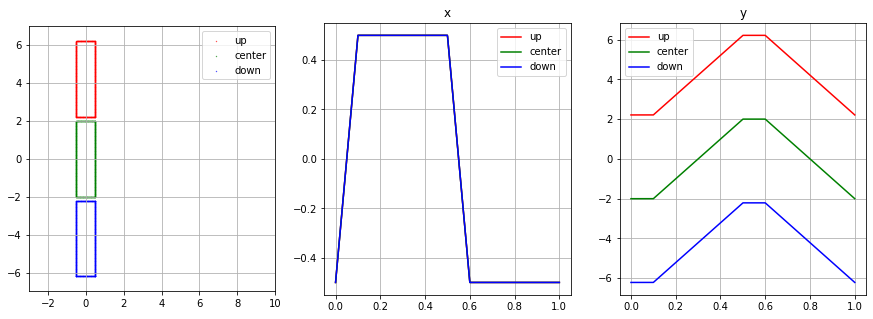

In [12]:
#
fig = plt.figure ( 0 , figsize = ( 15, 5 ) )

#
s = 0.1
ax = fig.add_subplot(131)
plt.scatter(df[("up","x")], df[("up","y")], color= "red",label="up",s=s)
plt.scatter(df[("center","x")], df[("center","y")], color= "green",label="center",s=s)
plt.scatter(df[("down","x")], df[("down","y")], color= "blue",label="down",s=s)
plt.grid()
plt.legend()
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)
ax.set_aspect('equal')

#
ax = fig.add_subplot(132)#, projection='3d')
ax.plot(df["t"],df[("up","x")],color="red",label="up")
ax.plot(df["t"],df[("center","x")],color="green",label="center")
ax.plot(df["t"],df[("down","x")],color="blue",label="down")
plt.grid(True)
plt.legend()
plt.title("x")

#
ax = fig.add_subplot(133)#, projection='3d')
ax.plot(df["t"],df[("up","y")],color="red",label="up")
ax.plot(df["t"],df[("center","y")],color="green",label="center")
ax.plot(df["t"],df[("down","y")],color="blue",label="down")
plt.grid(True)
plt.legend()
plt.title("y")


plt.show()

### Stiffness Matrix

files/BEM/Young/stiffness_matrix-P=1-N=100-k=30.csv


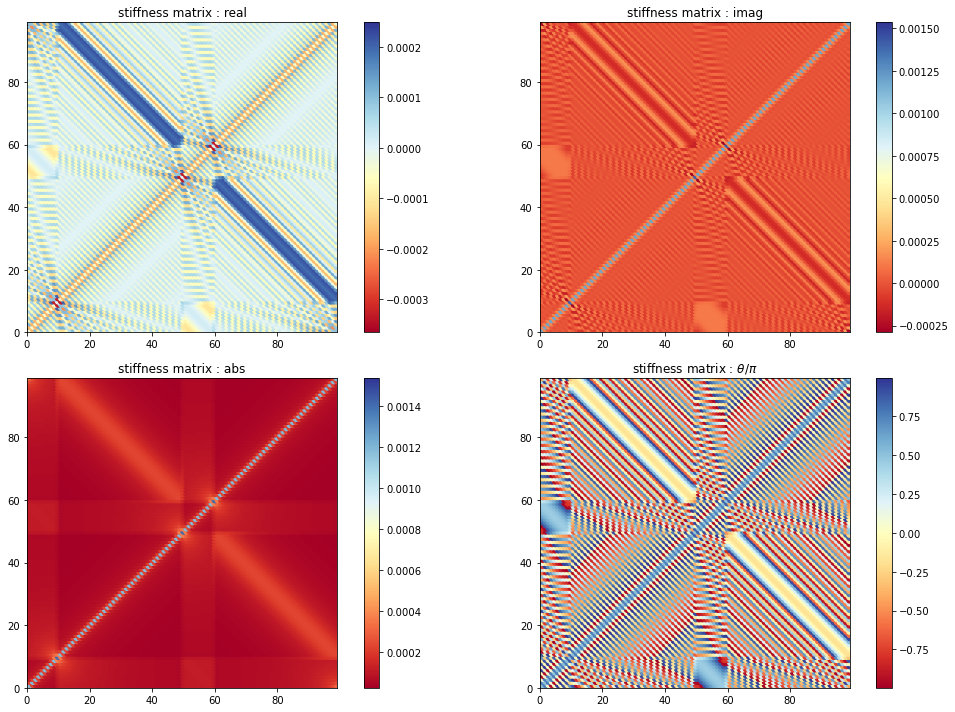

In [12]:
READ = True
SAVE = False

#names = ["up","center","down"]
opts = {"print":True,"N":[6],"ready_sm_BEM":True,"return_both":False}
#sm = [None,None,None]

#for b,n,i in zip(bs,names,[0,1,2]):    
    
file = file_dir+"stiffness_matrix-"+ suffixPNK+".csv"
file_png = file_dir+"stiffness_matrix-"+suffixPNK +".png"

print(file)

if os.path.exists(file) and READ == True :
    sm = bs.load("sm-BEM",file)
else :
    sm = bs.stiffness_matrix_BEM(k=wavevector,opts=opts)

    if SAVE == True :
        bs.save("sm-BEM",file)

plot_matrix(sm,file_png)

### Single Layer Potential basis

In [13]:
Nx= 20#int(xmax-xmin)*10
Ny = 100#int(ymax-ymin)*10
x = np.linspace(xmin,xmax,Nx)
y = np.linspace(ymin,ymax,Ny)
X,Y = np.meshgrid(x,y)

XY = np.zeros((Nx*Ny,2))
XY[:,0] = X.reshape((Nx*Ny,))
XY[:,1] = Y.reshape((Nx*Ny,))

r = [r0,r1,r2]

for t in r:
    t = np.asarray(t)
    bs.traslate_cp(t)
    internal = bs.internal_points(XY=XY,NN=1000,xmin=0.,xmax=1.,opts=None)
    XY = XY[ np.logical_not(internal) ]
    bs.traslate_cp(-t)
    
print(len(XY))

1664


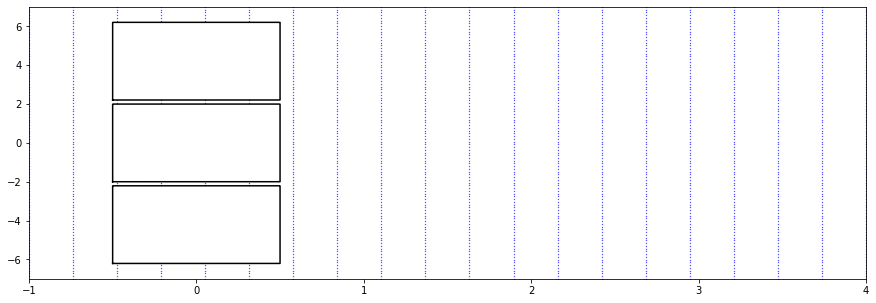

In [37]:
#
fig = plt.figure ( 0 , figsize = ( 15, 5 ) )
#
ax = fig.add_subplot(111)
plt.plot(df[("up","x")], df[("up","y")], color= "black",label="up")
plt.plot(df[("center","x")], df[("center","y")], color= "black",label="center")
plt.plot(df[("down","x")], df[("down","y")], color= "black",label="down")
plt.scatter(XY[:,0],XY[:,1], color= "blue",label="points",s=0.1)
#plt.grid()
#plt.legend()
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)
#ax.set_aspect('equal')
plt.show()

In [14]:
READ = True
SAVE = True

#names = ["up","center","down"]
opts = {"print":True,"N":[6]}#,"equal":[ [(0,0),(1,1)] , [(0,0),(2,2)] , [(0,1),(1,2)] ]}

#for b,n,i in zip(bs_arr,names,[0,1,2]):
        
file = file_dir+"single_layer_potential-"+suffixPNK + ".csv"

print(file)

if os.path.exists(file) and READ == True :
    print("reading file ",file)
    slp = bs.load("slp-BEM",file)

slp = bs.single_layer_potential_basis_BEM(XY=XY,k=wavevector,opts=opts)    

if SAVE == True :
    bs.save("slp-BEM",file)

slp.head()    

files/BEM/Young/single_layer_potential-P=1-N=100-k=30.csv
reading file  files/BEM/Young/single_layer_potential-P=1-N=100-k=30.csv
single_layer_potential_basis_BEM


,"(0,)","(1,)","(2,)","(3,)","(4,)","(5,)","(6,)","(7,)","(8,)","(9,)",...,"(90,)","(91,)","(92,)","(93,)","(94,)","(95,)","(96,)","(97,)","(98,)","(99,)"
"(-3.0, -6.0)",0.000593-0.000669j,0.000693-0.000221j,0.000616+0.000382j,0.000098+0.000714j,-0.000494+0.000520j,-0.000711-0.000071j,-0.000368-0.000608j,0.000274-0.000652j,0.000688-0.000150j,0.000509+0.000481j,...,-0.000349+0.000450j,0.000465+0.000333j,0.000318-0.000479j,-0.000492-0.000303j,-0.000290+0.000504j,0.000514+0.000278j,0.000267-0.000523j,-0.000531-0.000258j,-0.000251+0.000538j,0.000544+0.000245j
"(-2.8686868686868685, -6.0)",-0.000757-0.000483j,-0.000351-0.000646j,0.000238-0.000692j,0.000672-0.000280j,0.000647+0.000326j,0.000162+0.000703j,-0.000445+0.000564j,-0.000714-0.000005j,-0.000424-0.000571j,0.000211-0.000676j,...,0.000451+0.000348j,0.000325-0.000471j,-0.000489-0.000303j,-0.000281+0.000506j,0.000521+0.000260j,0.000239-0.000534j,-0.000545-0.000219j,-0.000201+0.000556j,0.000565+0.000184j,0.000168-0.000574j
"(-2.7373737373737375, -6.0)",-0.000422+0.000797j,-0.000607+0.000426j,-0.000726-0.000133j,-0.000403-0.000615j,0.000178-0.000710j,0.000646-0.000337j,0.000674+0.000268j,0.000224+0.000686j,-0.000392+0.000602j,-0.000712+0.000061j,...,0.000379-0.000426j,-0.000453-0.000351j,-0.000324+0.000477j,0.000498+0.000295j,0.000267-0.000517j,-0.000534-0.000239j,-0.000211+0.000549j,0.000562+0.000184j,0.000158-0.000574j,-0.000583-0.000133j
"(-2.606060606060606, -6.0)",0.000801+0.000423j,0.000452+0.000597j,-0.000080+0.000741j,-0.000572+0.000473j,-0.000735-0.000074j,-0.000453-0.000580j,0.000118-0.000723j,0.000615-0.000391j,0.000695+0.000208j,0.000284+0.000664j,...,-0.000368-0.000436j,-0.000408+0.000403j,0.000436+0.000377j,0.000346-0.000465j,-0.000492-0.000313j,-0.000279+0.000515j,0.000536+0.000245j,0.000210-0.000553j,-0.000569-0.000176j,-0.000143+0.000582j
"(-2.474747474747475, -6.0)",0.000486-0.000769j,0.000622-0.000429j,0.000747+0.000085j,0.000495+0.000562j,-0.000023+0.000745j,-0.000533+0.000516j,-0.000739-0.000014j,-0.000499-0.000541j,0.000057-0.000730j,0.000579-0.000443j,...,-0.000506+0.000264j,0.000311+0.000482j,0.000455-0.000355j,-0.000396-0.000424j,-0.000390+0.000433j,0.000466+0.000355j,0.000317-0.000497j,-0.000523-0.000279j,-0.000239+0.000546j,0.000565+0.000199j


In [16]:
bs.copy()

In [17]:
bs_arr = [bs.copy(),bs.copy(),bs.copy()]

In [15]:
READ = False
SAVE = True

names = ["up","center","down"]
opts = {"print":True,"N":[6],"equal":[ [(0,0),(1,1)] , [(0,0),(2,2)] , [(0,1),(1,2)] ]}

bs_arr = [bs.copy(),bs.copy(),bs.copy()]
bs_arr[0].traslate_cp(r0)
bs_arr[1].traslate_cp(r1)
bs_arr[2].traslate_cp(r2)

for b,n,i in zip(bs_arr,names,[0,1,2]):
        
    file = file_dir+"single_layer_potential-"+n+"-"+suffixPN + ".csv"
    
    print(n,"->",file)
    
    if os.path.exists(file) and READ == True :
        slp = b.load("slp-BEM",file)
        
    slp = b.single_layer_potential_basis_BEM(XY=XY,k=wavevector,opts=opts)    
    
    if SAVE == True :
        b.save("slp-BEM",file)
        
    slp.head()    

up -> files/BEM/Young/single_layer_potential-up-P=1-N=100.csv
single_layer_potential_basis_BEM
Calculating "partial solution" for  7523  points
Finished523
Updating slp matrix
center -> files/BEM/Young/single_layer_potential-center-P=1-N=100.csv
single_layer_potential_basis_BEM
Calculating "partial solution" for  7523  points
Finished523
Updating slp matrix
down -> files/BEM/Young/single_layer_potential-down-P=1-N=100.csv
single_layer_potential_basis_BEM
Calculating "partial solution" for  7523  points
Finished523
Updating slp matrix


### Plane wave

#### Preparation

In [15]:
def plane_wave(xx): # soluzione
    xx = np.asarray(xx)
    theta = np.dot(xx,k_in)
    return np.exp(I*theta)

In [16]:
df[("up","z")]     = plane_wave(df[[("up","x"),("up","y")]])
df[("center","z")] = plane_wave(df[[("center","x"),("center","y")]])
df[("down","z")]   = plane_wave(df[[("down","x"),("down","y")]])
df  = df[ [("up","x")     , ("up","y")    ,("up","z")    ,\
          ("center","x") , ("center","y"),("center","z"),\
          ("down","x")   , ("down","y")  ,("down","z")]  ]
df.head()

up                                center                           \
         x        y                   z        x    y                   z   
0 -0.50000  2.20944 -0.759688-0.650288j -0.50000 -2.0 -0.759688-0.650288j   
1 -0.48999  2.20944 -0.533330-0.845907j -0.48999 -2.0 -0.533330-0.845907j   
2 -0.47998  2.20944 -0.259237-0.965814j -0.47998 -2.0 -0.259237-0.965814j   
3 -0.46997  2.20944  0.038059-0.999276j -0.46997 -2.0  0.038059-0.999276j   
4 -0.45996  2.20944  0.331948-0.943298j -0.45996 -2.0  0.331948-0.943298j   

      down                               
         x        y                   z  
0 -0.50000 -6.20944 -0.759688-0.650288j  
1 -0.48999 -6.20944 -0.533330-0.845907j  
2 -0.47998 -6.20944 -0.259237-0.965814j  
3 -0.46997 -6.20944  0.038059-0.999276j  
4 -0.45996 -6.20944  0.331948-0.943298j

In [42]:
#
NN = 1000
t = np.linspace(xminBs,xmaxBs,NN,endpoint=True)
df = pd.DataFrame(index=np.arange(0,len(t)),columns=np.arange(0,6),dtype=object)
index = [ ("up","x")     , ("up","y")    ,("up","z")    ,\
          ("center","x") , ("center","y"),("center","z"),\
          ("down","x")   , ("down","y")  ,("down","z")  ]
mi = pd.MultiIndex.from_tuples(index)
df = df.reindex(columns=mi)

df["t"]      = t

xy = bs.evaluate(t)
#c = center.evaluate(t)
#d =  down.evaluate(t)

df[("up","x")]  = xy[:,0] + r0[0]
df[("up","y")]  = xy[:,1] + r0[1]
df[("up","z")]  = xy[:,1] + r0[1]

df[("center","x")] = xy[:,0] + r1[0]
df[("center","y")] = xy[:,1] + r1[1]
df[("center","z")] = xy[:,1] + r1[1]

df[("down","x")]   = xy[:,0] + r2[0]
df[("down","y")]   = xy[:,1] + r2[1]
df[("down","z")]   = xy[:,1] + r2[1]

df.head()

up            center          down                  t
         x        y        x    y        x        y          
0 -0.50000  2.20944 -0.50000 -2.0 -0.50000 -6.20944  0.000000
1 -0.48999  2.20944 -0.48999 -2.0 -0.48999 -6.20944  0.001001
2 -0.47998  2.20944 -0.47998 -2.0 -0.47998 -6.20944  0.002002
3 -0.46997  2.20944 -0.46997 -2.0 -0.46997 -6.20944  0.003003
4 -0.45996  2.20944 -0.45996 -2.0 -0.45996 -6.20944  0.004004

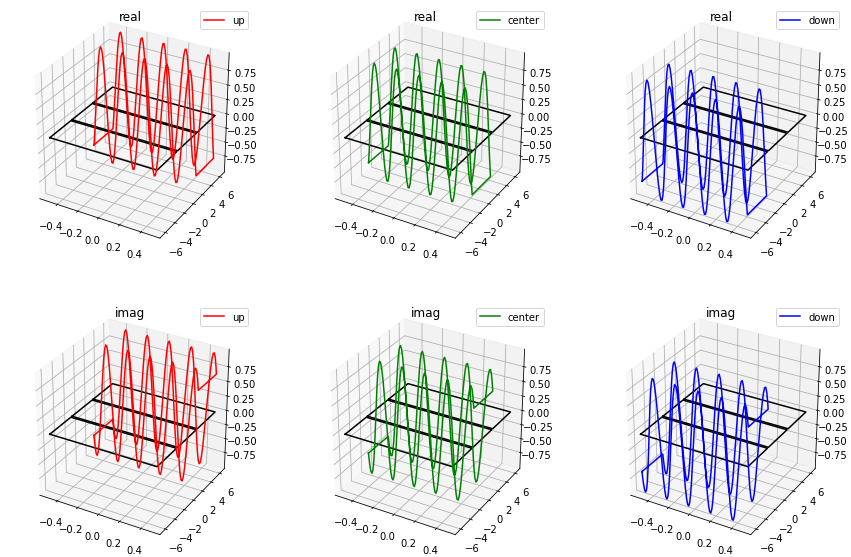

In [53]:
#
fig = plt.figure ( 0 , figsize = ( 15, 10 ) )

##########################################
ax = fig.add_subplot(231, projection='3d')
ax.plot(df[("up","x")]    ,df[("up","y")]    ,0 ,color= "black")#,label="up")
ax.plot(df[("center","x")],df[("center","y")],0 ,color= "black")#,label="center")
ax.plot(df[("down","x")]  ,df[("down","y")]  ,0 ,color= "black")#,label="down")

ax.plot(df[("up","x")]    ,df[("up","y")]    ,np.real(df[("up","z")])    ,color= "red",label="up")
#ax.plot(df[("center","x")],df[("center","y")],np.real(df[("center","z")]),color= "green",label="center")
#ax.plot(df[("down","x")]  ,df[("down","y")]  ,np.real(df[("down","z")])  ,color= "blue",label="down")
plt.grid(True)
plt.legend()
plt.title("real")

#
ax = fig.add_subplot(234, projection='3d')
ax.plot(df[("up","x")]    ,df[("up","y")]    ,0 ,color= "black")#,label="up")
ax.plot(df[("center","x")],df[("center","y")],0 ,color= "black")#,label="center")
ax.plot(df[("down","x")]  ,df[("down","y")]  ,0 ,color= "black")#,label="down")

ax.plot(df[("up","x")]    ,df[("up","y")]    ,np.imag(df[("up","z")])    ,color= "red",label="up")
#ax.plot(df[("center","x")],df[("center","y")],np.imag(df[("center","z")]),color= "green",label="center")
#ax.plot(df[("down","x")]  ,df[("down","y")]  ,np.imag(df[("down","z")])  ,color= "blue",label="down")
plt.grid(True)
plt.legend()
plt.title("imag")

##########################################
ax = fig.add_subplot(232, projection='3d')
ax.plot(df[("up","x")]    ,df[("up","y")]    ,0 ,color= "black")#,label="up")
ax.plot(df[("center","x")],df[("center","y")],0 ,color= "black")#,label="center")
ax.plot(df[("down","x")]  ,df[("down","y")]  ,0 ,color= "black")#,label="down")

#ax.plot(df[("up","x")]    ,df[("up","y")]    ,np.real(df[("up","z")])    ,color= "red",label="up")
ax.plot(df[("center","x")],df[("center","y")],np.real(df[("center","z")]),color= "green",label="center")
#ax.plot(df[("down","x")]  ,df[("down","y")]  ,np.real(df[("down","z")])  ,color= "blue",label="down")
plt.grid(True)
plt.legend()
plt.title("real")

#
ax = fig.add_subplot(235, projection='3d')
ax.plot(df[("up","x")]    ,df[("up","y")]    ,0 ,color= "black")#,label="up")
ax.plot(df[("center","x")],df[("center","y")],0 ,color= "black")#,label="center")
ax.plot(df[("down","x")]  ,df[("down","y")]  ,0 ,color= "black")#,label="down")

#ax.plot(df[("up","x")]    ,df[("up","y")]    ,np.imag(df[("up","z")])    ,color= "red",label="up")
ax.plot(df[("center","x")],df[("center","y")],np.imag(df[("center","z")]),color= "green",label="center")
#ax.plot(df[("down","x")]  ,df[("down","y")]  ,np.imag(df[("down","z")])  ,color= "blue",label="down")
plt.grid(True)
plt.legend()
plt.title("imag")

##########################################
ax = fig.add_subplot(233, projection='3d')
ax.plot(df[("up","x")]    ,df[("up","y")]    ,0 ,color= "black")#,label="up")
ax.plot(df[("center","x")],df[("center","y")],0 ,color= "black")#,label="center")
ax.plot(df[("down","x")]  ,df[("down","y")]  ,0 ,color= "black")#,label="down")

#ax.plot(df[("up","x")]    ,df[("up","y")]    ,np.real(df[("up","z")])    ,color= "red",label="up")
#ax.plot(df[("center","x")],df[("center","y")],np.real(df[("center","z")]),color= "green",label="center")
ax.plot(df[("down","x")]  ,df[("down","y")]  ,np.real(df[("down","z")])  ,color= "blue",label="down")
plt.grid(True)
plt.legend()
plt.title("real")

#
ax = fig.add_subplot(236, projection='3d')
ax.plot(df[("up","x")]    ,df[("up","y")]    ,0 ,color= "black")#,label="up")
ax.plot(df[("center","x")],df[("center","y")],0 ,color= "black")#,label="center")
ax.plot(df[("down","x")]  ,df[("down","y")]  ,0 ,color= "black")#,label="down")

#ax.plot(df[("up","x")]    ,df[("up","y")]    ,np.imag(df[("up","z")])    ,color= "red",label="up")
#ax.plot(df[("center","x")],df[("center","y")],np.imag(df[("center","z")]),color= "green",label="center")
ax.plot(df[("down","x")]  ,df[("down","y")]  ,np.imag(df[("down","z")])  ,color= "blue",label="down")
plt.grid(True)
plt.legend()
plt.title("imag")

plt.show()

In [64]:
def plot(fig,n,xB,yB,x,y,c,title,cmap):
    
    ax = fig.add_subplot(n)
    ax.scatter(xB, yB, color= "black",label="Bspline")
    sc = ax.scatter(x,y,c=c,cmap=cmap)
    plt.colorbar(sc)
    #ax.set_aspect('equal')
    #plt.xlim(min(x),max(x))
    #plt.ylim(min(y),max(y))
    plt.title(title)
    
    return

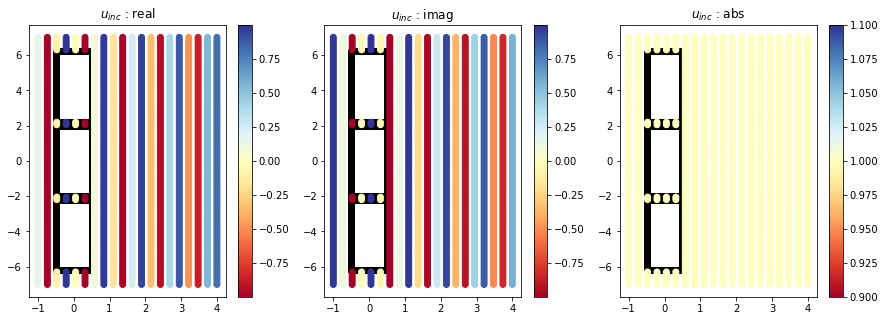

In [65]:
#
fig = plt.figure ( 0 , figsize = ( 15 , 5 ) )

Uinc = plane_wave(XY)

cmap = 'RdYlBu'

x = np.concatenate((np.asarray(df[("up","x")]),\
                    np.asarray(df[("center","x")]),\
                    np.asarray(df[("down","x")])))

y = np.concatenate((np.asarray(df[("up","y")]),\
                    np.asarray(df[("center","y")]),\
                    np.asarray(df[("down","y")])))
    
plot(fig,131,x,y,XY[:,0],XY[:,1],Uinc.real,"$u_{inc}$ : real",cmap)
plot(fig,132,x,y,XY[:,0],XY[:,1],Uinc.imag,"$u_{inc}$ : imag",cmap)
plot(fig,133,x,y,XY[:,0],XY[:,1],np.absolute(Uinc),"$u_{inc}$ : abs",cmap)

plt.show()

#### Solution

In [17]:
file_sol = file_dir+"solution-plane_wave-"+suffixPNK+".csv"
file_lv  = file_dir+"load_vector-plane_wave-"+suffixPNK+".csv"
file_ind = file_dir+"indirect_solution-plane_wave-"+suffixPNK+".csv"
print(file_sol)
print(file_lv)
print(file_ind)

files/BEM/Young/solution-plane_wave-P=1-N=100-k=30.csv
files/BEM/Young/load_vector-plane_wave-P=1-N=100-k=30.csv
files/BEM/Young/indirect_solution-plane_wave-P=1-N=100-k=30.csv


In [58]:
reload(Bs)

<module 'pyBspline' from 'C:\\Users\\user\\Google Drive\\Universita\\ANM4PDE\\code\\python\\pyBspline.py'>

In [18]:
opts = {"print":True,"N":[6],"equal":[ [(0,0),(1,1)] , [(0,0),(2,2)] , [(0,1),(1,2)] ]}

bs_arr = [bs.copy(),bs.copy(),bs.copy()]
bs_arr[0].traslate_cp(r0)
bs_arr[1].traslate_cp(r1)
bs_arr[2].traslate_cp(r2)

In [ ]:
#opts = {"print":False}
SLP,Xnp,Valnp = Bs.BEM_disconnected(bs=bs_arr,uinc=plane_wave,k=wavevector,XY=XY,opts=opts)

In [ ]:
file = file_dir+"solution-plane_wave-"+suffixPNK+".csv"
SLP.to_csv(file,index_label="index")

In [24]:
file = file_dir+"SM-plane_wave-"+suffixPNK+".csv"
Bs._sm_BEM_disc.to_csv(file,index_label="index")

In [25]:
file = file_dir+"LV-plane_wave-"+suffixPNK+".csv"
Bs._lv_BEM_disc.to_csv(file,index_label="index")

In [38]:
#
READ = False
SAVE = True
if os.path.exists(file_sol) and READ == True :
    sol,Xnp,Valnp = bs.load("sol-BEM",file_sol)
    
if os.path.exists(file_lv) and READ == True :
    lv = bs.load("lv-BEM",file_lv)
    
if os.path.exists(file_ind) and READ == True :
    sol = bs.load("ind_sol-BEM",file_ind)
    
else :
    opts = {"print":True}#,"ready_sol_BEM":True,"ready_lv_BEM":True,"ready_ind_sol_BEM":True}
    SLP,Xnp,Valnp = bs.BEM(uinc=plane_wave,k=wavevector,XY=XY,opts=opts)
    if SAVE == True :
        bs.save("sol-BEM",file_sol)
        bs.save("lv-BEM",file_lv)
        bs.save("ind_sol-BEM",file_ind)
sol.head()

single_layer_potential_basis_BEM


,x,value
"(-3.0, -3.0)","(-3.0, -3.0)",(0.021450319060675467+0.23972051479116754j)
"(-2.8983050847457625, -3.0)","(-2.8983050847457625, -3.0)",(0.11878564627911543+0.17885217744278092j)
"(-2.7966101694915255, -3.0)","(-2.7966101694915255, -3.0)",(0.19325138927451285+0.10235650973732625j)
"(-2.694915254237288, -3.0)","(-2.694915254237288, -3.0)",(0.22288056135086862+0.00043417807640387315j)
"(-2.593220338983051, -3.0)","(-2.593220338983051, -3.0)",(0.20262474323786026-0.1030014167209779j)


In [26]:
#
Uinc = plane_wave(XY)#.reshape(Nx,Ny).transpose()
total = Uinc + Valnp

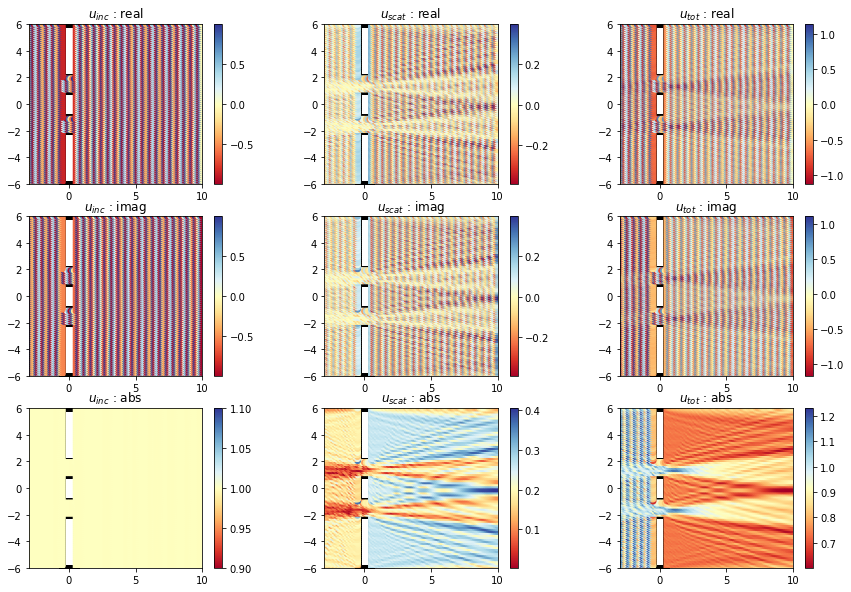

In [27]:
#
fig = plt.figure ( 0 , figsize = ( 15 , 10 ) )

cmap = 'RdYlBu'

x = np.concatenate((np.asarray(df[("up","x")]),\
                    np.asarray(df[("center","x")]),\
                    np.asarray(df[("down","x")])))

y = np.concatenate((np.asarray(df[("up","y")]),\
                    np.asarray(df[("center","y")]),\
                    np.asarray(df[("down","y")])))
    
plot(fig,331,x,y,XY[:,0],XY[:,1],Uinc.real,"$u_{inc}$ : real",cmap)
plot(fig,334,x,y,XY[:,0],XY[:,1],Uinc.imag,"$u_{inc}$ : imag",cmap)
plot(fig,337,x,y,XY[:,0],XY[:,1],np.absolute(Uinc),"$u_{inc}$ : abs",cmap)

plot(fig,332,x,y,XY[:,0],XY[:,1],Valnp.real,"$u_{scat}$ : real",cmap)
plot(fig,335,x,y,XY[:,0],XY[:,1],Valnp.imag,"$u_{scat}$ : imag",cmap)
plot(fig,338,x,y,XY[:,0],XY[:,1],np.absolute(Valnp),"$u_{scat}$ : abs",cmap)

plot(fig,333,x,y,XY[:,0],XY[:,1],total.real,"$u_{tot}$ : real",cmap)
plot(fig,336,x,y,XY[:,0],XY[:,1],total.imag,"$u_{tot}$ : imag",cmap)
plot(fig,339,x,y,XY[:,0],XY[:,1],np.absolute(total),"$u_{tot}$ : abs",cmap)

plt.show()

In [28]:
SLP

,x,value,0,1,2
"(-3.0, -6.0)","(-3.0, -6.0)",0.132352+0.015850j,(0.0009413226817155534+0.046559629797515184j),(0.03714540683494924-0.02912837200449888j),(0.3589699932619306+0.030118898055428514j)
"(-2.8686868686868685, -6.0)","(-2.8686868686868685, -6.0)",-0.083812+0.079406j,(0.04138192936868303+0.018388854856384456j),(-0.027287615195499458-0.028648696579988083j),(-0.2655304638634389+0.24847833910289813j)
"(-2.7373737373737375, -6.0)","(-2.7373737373737375, -6.0)",0.008320-0.127590j,(0.0346726824525449-0.02769284973932678j),(-0.02216236568524285+0.02352214903786736j),(0.012450102263356064-0.3786003208098233j)
"(-2.606060606060606, -6.0)","(-2.606060606060606, -6.0)",0.088192+0.083090j,(-0.0065795444458470985-0.04337543391003609j),(0.019869239223082123+0.01748546007932398j),(0.2512860028983749+0.2751601169943728j)
"(-2.474747474747475, -6.0)","(-2.474747474747475, -6.0)",-0.132079-0.011542j,(-0.03985760981675961-0.017975297777780314j),(0.014649735626019641-0.017744164462640873j),(-0.3710280931069615+0.0010945167450757548j)
...,...,...,...,...,...
"(9.474747474747476, 6.0)","(9.474747474747476, 6.0)",-0.057402-0.156737j,(-0.09709135035684555-0.48528327152430856j),(-0.08049911043844823-0.019139962748069197j),(0.005384878257476015+0.034213325539117254j)
"(9.606060606060607, 6.0)","(9.606060606060607, 6.0)",-0.069084+0.141606j,(-0.26837555748114283+0.4015759119695799j),(0.06857976656164956+0.05147256919262126j),(-0.007456243066618042-0.02823032625118552j)
"(9.737373737373739, 6.0)","(9.737373737373739, 6.0)",0.140926-0.047650j,(0.46214523157564574-0.08776822051213284j),(-0.04489076893654805-0.07783430200260995j),(0.005524035125476952+0.022652430448808724j)
"(9.86868686868687, 6.0)","(9.86868686868687, 6.0)",-0.121112-0.063309j,(-0.3745537766423268-0.2639894691812382j),(0.012017830358062788+0.09362793411507454j),(-0.0007986893538872494-0.01956534644258071j)


In [29]:
#grafico
fig = plt.figure ( 0 , figsize = ( 15 , 10 ) )

cmap = 'RdYlBu'

   
plot_sol(fig,331,df["x"], df["y"],XY[:,0],XY[:,1],Uinc.real,"$u_{inc}$ : real")
plot_sol(fig,334,df["x"], df["y"],XY[:,0],XY[:,1],Uinc.imag,"$u_{inc}$ : imag")
plot_sol(fig,337,df["x"], df["y"],XY[:,0],XY[:,1],np.absolute(Uinc),"$u_{inc}$ : abs")

plot_sol(fig,332,df["x"], df["y"],XY[:,0],XY[:,1],Valnp.real,"$u_{scat}$ : real")
plot_sol(fig,335,df["x"], df["y"],XY[:,0],XY[:,1],Valnp.imag,"$u_{scat}$ : imag")
plot_sol(fig,338,df["x"], df["y"],XY[:,0],XY[:,1],np.absolute(Valnp),"$u_{scat}$ : abs")

plot_sol(fig,333,df["x"], df["y"],XY[:,0],XY[:,1],total.real,"$u_{tot}$ : real")
plot_sol(fig,336,df["x"], df["y"],XY[:,0],XY[:,1],total.imag,"$u_{tot}$ : imag")
plot_sol(fig,339,df["x"], df["y"],XY[:,0],XY[:,1],np.absolute(total),"$u_{tot}$ : abs")

plt.tight_layout()

sol_png = file_dir+"solution-n=6-random=False-"+suffix_png
plt.savefig(sol_png)

plt.show()

KeyError: 'x'

<Figure size 1080x720 with 0 Axes>

### Herglotz

#### Kernel

In [ ]:
#definisco la dimensionaità:
sh = Bs.shape(1,1)
#sh.show()

#defiisco i knot vector
P=0 #polinomial degree
N=12 #base caridnality

#
#kv = Bs.uniform_open_kv(xmin,xmax,p=P,n=N)#Bs.knot_vector(P,N,v)
#kv = periodic_kv(xmin,xmax,p=P,n=N)
kv = Bs.periodic_kv(0.0,2*np.pi,p=P,n=N)
#kv.show()

#alloco la Bspline
kernel = Bs.Bspline(sh,[kv],properties={"periodic":[True],"dtype":np.complex})
#bs.show()

kernel.clear_cp()
kernel.set_cp(0,1)

In [ ]:
#
NN = 1000
T = np.linspace(0.0,2*np.pi,NN,endpoint=False)
y   = kernel.evaluate(T)
#df = pd.DataFrame(xy)
#df = df.rename(columns={0:"x",1:"y"})

In [ ]:
fig = plt.figure ( 0 , figsize = ( 15, 5 ) )

#real
ax = fig.add_subplot(111)#, projection='3d')
ax.plot(T,y.real,color="blue",label="real")
ax.plot(T,y.imag,color="green",label="imag")
plt.xlabel(r"$\theta \, \left[ rad \right]$")
plt.title(r"Herglotz kernel $\, g \left( \theta \right) \, : 1 \, $ if $ \,  - \pi/6 < \theta < \pi/6$")
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
def Herglotz_private(xy,kernel,k,NN):
    xy = np.asarray(xy)
    theta = np.linspace(0.,2*np.pi,NN,endpoint=False)
    cos = np.cos(theta)
    sin = np.sin(theta)
    g = kernel(theta)
    phase = np.outer(xy[:,0],cos) + np.outer(xy[:,1],sin)
    expo = np.exp(1.j*phase*k)
    return np.dot(expo,g)/NN

In [ ]:
#k = 30./4.
NN = 100
def Herglotz(xy): 
    return Herglotz_private(xy,kernel,wavevector,NN)

In [ ]:
Nx= int(xmax-xmin)*10
Ny = int(ymax-ymin)*10
x = np.linspace(xmin,xmax,Nx)
y = np.linspace(ymin,ymax,Ny)
X,Y = np.meshgrid(x,y)

XY = np.zeros((Nx*Ny,2))
XY[:,0] = X.reshape((Nx*Ny,))
XY[:,1] = Y.reshape((Nx*Ny,))

x = XY[:,0]
y = XY[:,1]

In [ ]:
Uinc = Herglotz(XY)

In [ ]:
#
fig = plt.figure ( 0 , figsize = ( 15 , 5 ) )

cmap = 'RdYlBu'

ax = fig.add_subplot(131)
#ax.plot(xB, yB, color= "black",label="Bspline")
sc = ax.scatter(x,y,c=Uinc.real,cmap=cmap)
plt.colorbar(sc)
ax.set_aspect('equal')
plt.xlim(min(x),max(x))
plt.ylim(min(y),max(y))
plt.title("real")

ax = fig.add_subplot(132)
#ax.plot(xB, yB, color= "black",label="Bspline")
sc = ax.scatter(x,y,c=Uinc.imag,cmap=cmap)
plt.colorbar(sc)
ax.set_aspect('equal')
plt.xlim(min(x),max(x))
plt.ylim(min(y),max(y))
plt.title("imag")

ax = fig.add_subplot(133)
#ax.plot(xB, yB, color= "black",label="Bspline")
sc = ax.scatter(x,y,c=np.absolute(Uinc),cmap=cmap)
plt.colorbar(sc)
ax.set_aspect('equal')
plt.xlim(min(x),max(x))
plt.ylim(min(y),max(y))
plt.title("abs")

#ax = fig.add_subplot(224)
##ax.plot(xB, yB, color= "black",label="Bspline")
#sc = ax.scatter(x,y,c=np.angle(Uinc),cmap=cmap)
#plt.colorbar(sc)
#ax.set_aspect('equal')
#plt.xlim(min(x),max(x))
#plt.ylim(min(y),max(y))
#plt.title("phase")

plt.show()

#### Preparation

In [ ]:
#
NN = 1000
T = np.linspace(xminBs,xmaxBs,NN,endpoint=True)
xy   = bs.evaluate(T)
uinc = Herglotz(xy)

In [ ]:
Nx= int(xmax-xmin)*10
Ny = int(ymax-ymin)*10
x = np.linspace(xmin,xmax,Nx)
y = np.linspace(ymin,ymax,Ny)
X,Y = np.meshgrid(x,y)

XY = np.zeros((Nx*Ny,2))
XY[:,0] = X.reshape((Nx*Ny,))
XY[:,1] = Y.reshape((Nx*Ny,))

internal = bs.internal_points(XY=XY0,NN=1000,xmin=0.,xmax=1.,opts=None)
XY = XY0[ np.logical_not(internal) ]

x = XY[:,0]
y = XY[:,1]

In [ ]:
#
fig = plt.figure ( 0 , figsize = ( 15, 5 ) )

#
#s = 0.2
ax = fig.add_subplot(121, projection='3d')
ax.plot(xy[:,0], xy[:,1],uinc.real,color="blue",label="real")
ax.plot(xy[:,0], xy[:,1],uinc.imag,color="green",label="imag")
ax.plot(xy[:,0], xy[:,1],0.0,color="red",label="Bspline")
plt.grid(True)
plt.legend()

#
ax = fig.add_subplot(122)#, projection='3d')
ax.plot(T,uinc.real,color="blue",label="real")
ax.plot(T,uinc.imag,color="green",label="imag")
plt.grid(True)
plt.legend()

#
#ax = fig.add_subplot(133)#, projection='3d')
#ax.plot(T,somma.real,color="blue",label="real")
#ax.plot(T,somma.imag,color="green",label="imag")
#plt.grid(True)
#plt.legend()

plt.show()

In [ ]:
#
fig = plt.figure ( 0 , figsize = ( 15 , 5 ) )

Uinc = Herglotz(XY)

cmap = 'RdYlBu'
    
plot(fig,121,df["x"], df["y"],XY[:,0],XY[:,1],Uinc.real,"$u_{inc}$ : real",cmap)
plot(fig,122,df["x"], df["y"],XY[:,0],XY[:,1],Uinc.imag,"$u_{inc}$ : imag",cmap)

plt.show()

#### Solution

In [ ]:
file_sol = file_dir+"solution-Herglotz-"+suffix
file_lv  = file_dir+"load_vector-Herglotz-"+suffix
file_ind = file_dir+"indirect_solution-Herglotz-"+suffix
print(file_sol)
print(file_lv)
print(file_ind)

In [ ]:
#
READ = True
SAVE = False
if os.path.exists(file_sol) and READ == True :
    sol,Xnp,Valnp = bs.load("sol-BEM",file_sol)
    
if os.path.exists(file_lv) and READ == True :
    lv = bs.load("lv-BEM",file_lv)
    
if os.path.exists(file_ind) and READ == True :
    sol = bs.load("ind_sol-BEM",file_ind)
    
else :
    opts = {"print":True,"ready_sol_BEM":False,"ready_lv_BEM":False,"ready_ind_sol_BEM":False}
    sol,Xnp,Valnp = bs.BEM(uinc=Herglotz,k=wavevector,XY=XY,opts=opts)
    if SAVE == True :
        bs.save("sol-BEM",file_sol)
        bs.save("lv-BEM",file_lv)
        bs.save("ind_sol-BEM",file_ind)
sol.head()

In [ ]:
#
Uinc = Herglotz(XY)#.reshape(Nx,Ny).transpose()
total = Uinc + Valnp

In [ ]:
#grafico
fig = plt.figure ( 0 , figsize = ( 15 , 10 ) )

cmap = 'RdYlBu'
    
plot_sol(fig,331,df["x"], df["y"],XY[:,0],XY[:,1],Uinc.real,"$u_{inc}$ : real")
plot_sol(fig,334,df["x"], df["y"],XY[:,0],XY[:,1],Uinc.imag,"$u_{inc}$ : imag")
plot_sol(fig,337,df["x"], df["y"],XY[:,0],XY[:,1],np.absolute(Uinc),"$u_{inc}$ : abs")

plot_sol(fig,332,df["x"], df["y"],XY[:,0],XY[:,1],Valnp.real,"$u_{scat}$ : real")
plot_sol(fig,335,df["x"], df["y"],XY[:,0],XY[:,1],Valnp.imag,"$u_{scat}$ : imag")
plot_sol(fig,338,df["x"], df["y"],XY[:,0],XY[:,1],np.absolute(Valnp),"$u_{scat}$ : abs")

plot_sol(fig,333,df["x"], df["y"],XY[:,0],XY[:,1],total.real,"$u_{tot}$ : real")
plot_sol(fig,336,df["x"], df["y"],XY[:,0],XY[:,1],total.imag,"$u_{tot}$ : imag")
plot_sol(fig,339,df["x"], df["y"],XY[:,0],XY[:,1],np.absolute(total),"$u_{tot}$ : abs")

plt.tight_layout()

sol_png = file_dir+"solution-n=6-random=False-"+suffix_png
plt.savefig(sol_png)

plt.show()

#### Analytic solution

In [ ]:
#
NN = 1000
T = np.linspace(xminBs,xmaxBs,NN,endpoint=True)
xy   = bs.evaluate(T)
uinc = Herglotz(xy)

In [ ]:
fft = esFFT.FFT(uinc,opts={"plot":True})

#
fig = plt.figure ( 0 , figsize = ( 15 , 5 ) )
ax = fig.add_subplot(111)
plt.plot(fft.index, np.real(fft["fft"]),color="blue" ,label="real")#,marker="+")
plt.plot(fft.index, np.imag(fft["fft"]),color="green",label="imag")#,marker="x")
plt.xlim(-20,20)
plt.legend()
plt.grid(True)
plt.title("Fourier Transform")
plt.show()
#
fft.head()

In [ ]:
bs = [kernel,kernel,kernel]

names = [ i for i in np.arange(len(bs)) ]
index = []
first = []
last  = []
for i in range(len(bs)):
    #il = bs[i].index_list()
    it = bs[i].dof().index#[tuple(j) for j in il ]
    first = first + [it[0]]
    last  = last  + [it[-1]]
    indexbs = [ (names[i],j) for j in it ]
    index = index + indexbs
    
#index = index_index + index_min + index_max

#
mi = pd.MultiIndex.from_tuples(index)
df = pd.DataFrame(columns=index,index=index)
SM = df.reindex(columns=mi,index=mi)


In [ ]:
for i in range(len(bs)):
    for j in range(i+1,len(bs)):
            
        bsLeft  = bs[i]
        bsRight = bs[j]
        sm = stiffness_matrix_BEM_disconnected(bsLeft,bsRight,k,opts)

        SM.loc[(i,first[i]):(i,last[i]),(j,first[j]):(j,last[j])] = sm
        SM.loc[(j,first[j]):(j,last[j]),(i,first[i]):(i,last[i])] = sm.T


In [ ]:
df.loc[(0,(0,)):(0,(4,)),(0,(0,))] = [1,2,3,4,5]


In [ ]:
last

In [131]:
from imp import reload 
reload(esFFT)

<module 'FFT' from 'C:\\Users\\user\\Google Drive\\Universita\\ANM4PDE\\code\\python\\FFT.py'>

In [ ]:
analytic = esFFT.analytic_solution_circle(uinc,XY,wmin=-15,wmax=15,radius=radius,wavevector=wavevector)

analytic_tot = Uinc + analytic

In [ ]:
#grafico
fig = plt.figure ( 0 , figsize = ( 15 , 10 ) )

cmap = 'RdYlBu'
    
plot_sol(fig,331,df["x"], df["y"],XY[:,0],XY[:,1],Valnp.real,"$u_{scat}^{Galerkin}$ : real")
plot_sol(fig,334,df["x"], df["y"],XY[:,0],XY[:,1],Valnp.imag,"$u_{scat}^{Galerkin}$ : imag")
plot_sol(fig,337,df["x"], df["y"],XY[:,0],XY[:,1],np.absolute(Valnp),"$u_{scat}^{Galerkin}$ : abs")

plot_sol(fig,332,df["x"], df["y"],XY[:,0],XY[:,1],analytic.real,"$u_{scat}^{analytic}$ : real")
plot_sol(fig,335,df["x"], df["y"],XY[:,0],XY[:,1],analytic.imag,"$u_{scat}^{analytic}$ : imag")
plot_sol(fig,338,df["x"], df["y"],XY[:,0],XY[:,1],np.absolute(analytic),"$u_{scat}^{analytic}$ : abs")

plot_sol(fig,333,df["x"], df["y"],XY[:,0],XY[:,1],Valnp.real-analytic.real,\
         "$u_{scat}^{Galerkin}-u_{scat}^{analytic}$ : real")
plot_sol(fig,336,df["x"], df["y"],XY[:,0],XY[:,1],Valnp.imag-analytic.imag,\
         "$u_{scat}^{Galerkin}-u_{scat}^{analytic}$ : imag")
plot_sol(fig,339,df["x"], df["y"],XY[:,0],XY[:,1],np.absolute(Valnp-analytic),\
         "$u_{scat}^{Galerkin}-u_{scat}^{analytic}$ : abs")


plt.tight_layout()

sol_png = file_dir+"solution-analytic-n=6-random=False-"+suffix_png
plt.savefig(sol_png)

plt.show()

- scelgo i punti in cui valutare la soluzione
- calcolo il valore della soluzione con $\psi_i$ al posto di $\psi$
- poi modificando $u_{inc}$ varierà $\psi$ ma potrò comunque sfruttare la matrice calcolata

- devo incrementare il numero di punti usati per calcolare la matrice di stiffness
- devo tener conto della periodicità nel domionio delle funzioni 
- devo tener conto che adesso il numero di funzioni di base è diverso da quello dei control points (perché alcuni sono periodici)
- creo una funzione che per ogni control point mi restituisce le funzioni di base associate, in questo modo posso riutilizzare le funzioni già scritte senza stravolgerle, devo però stare attento agli indici delle matrici

- ci sarebbe anche da riordinare il modo in cui salvo le varie matrici, sarebbe comodo usare un dict, in questo modo in ogni funzione posso usare la stessa porzione di codice variando soltanto alcuni parametri passati come stringhe

- devo creare delle Bspline periodiche
- l'ultimo control points non deve essere accessibile
- devo modificare le funzioni di approssimazione
- devo togliere dalle matrici le righe che corrispondono ai dof periodici dopo aver sommato il loro contributo agli altri dof
- sistemare solo la funzione approximate per adesso

- approximate
- edge
- Dirichlet_BC
- Galerkin

cioè solo le funzioni che vanno a modificare i control points della Bspline

- devo creare una funzione, che faccia uso dei dataframe, che sappia calcolarmi la Trasformata di Fourier in modo \textit{intuitivo}
- sfruttare poi quanto fatto per calcolare la trasformata di Fourier della funzione $g_D$ e calcolare la soluzione esatta di scattering da disco di raggio $R$
- attenzione, non so quanto valga di preciso il raggio del mio disco, devo implementare la funzione \textit{approximate} in modo tale poi da definire la funzione che mappa $t\in\left[0,1\right]\rightarrow \mathbf{S}\in\mathbf{R}^2$ e poi approssimarla 

- anche nel grafico che avevo ottenuto la volta scorso sembra esserci un errore, poiché nella stiffness matrix gli elementi diagonali sono molti più "intensi", adesso dovrei aver raffinato il passo d'integrazione
- generando 4 punti dovrei ottenere 4x4 coppie xy, di cui 4 con x=y, quindi ottengo una media su 10 punti
- adesso genero 16 punti quindi 16x16 coppie xy, quindi una media su 240 punti